In [2]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [3]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [4]:
device

device(type='mps')

In [5]:
IMG_SIZE = 128
BATCH_SIZE = 32

In [6]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

In [7]:
full_dataset = ImageFolder(root="dataset", transform=transform)

In [9]:
from torch.utils.data import random_split, DataLoader

train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


In [10]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [11]:
class PlantCNN(nn.Module):
    def __init__(self, num_classes):
        super(PlantCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * (IMG_SIZE//4) * (IMG_SIZE//4), 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

In [13]:
num_classes = len(full_dataset.classes)
model = PlantCNN(num_classes).to(device)

In [14]:
print(full_dataset.classes)

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss, correct = 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()

    accuracy = correct / len(train_dataset)
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {total_loss:.4f}, Train Accuracy: {accuracy:.4f}")

Epoch [1/10], Loss: 673.1371, Train Accuracy: 0.5777
Epoch [2/10], Loss: 363.7914, Train Accuracy: 0.7627
Epoch [3/10], Loss: 257.5697, Train Accuracy: 0.8318
Epoch [4/10], Loss: 208.2842, Train Accuracy: 0.8612
Epoch [5/10], Loss: 172.5752, Train Accuracy: 0.8842
Epoch [6/10], Loss: 139.5779, Train Accuracy: 0.9076
Epoch [7/10], Loss: 119.8017, Train Accuracy: 0.9192
Epoch [8/10], Loss: 102.0643, Train Accuracy: 0.9311
Epoch [9/10], Loss: 93.8304, Train Accuracy: 0.9369
Epoch [10/10], Loss: 87.4523, Train Accuracy: 0.9400


In [17]:
model.eval()
correct = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        correct += (outputs.argmax(1) == labels).sum().item()

test_accuracy = correct / len(test_dataset)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Test Accuracy: 90.41%


In [18]:
torch.save(model.state_dict(), "crop_disease_model.pth")
print("Model saved as crop_disease_model.pth ✅")

Model saved as crop_disease_model.pth ✅


In [23]:
def predict_image(img_path):
    img = Image.open(img_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        pred_class = output.argmax(1).item()
    class_name = class_names[pred_class]
    plt.imshow(img)
    plt.title(f"Predicted: {class_name}")
    plt.axis('off')
    plt.show()

In [22]:
class_names = full_dataset.classes

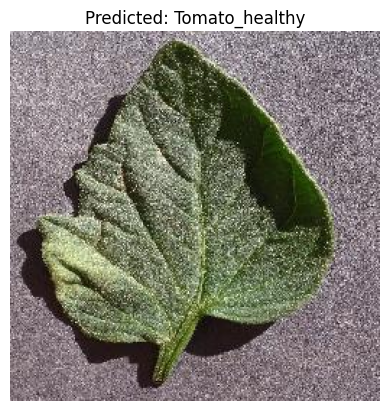

In [24]:
predict_image("dataset/Tomato_healthy/0a0d6a11-ddd6-4dac-8469-d5f65af5afca___RS_HL 0555.JPG")